# **NOTEBOOK 3: MODELS**

In this notebook, we are going to test different algorithms to predict how many parcels will be registered in the system the next day.

---

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#from fbprophet import Prophet

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

In [2]:
xgb.__version__

'0.90'

In [3]:
# url initial data
url = '../files/data/daytypelags2017_parcels.csv'
# read the previous CSV file with the data (parcels, calendar data and lags)
df_complete_models = pd.read_csv(url, sep=",", 
                                 index_col='date')
df_complete_models.index = pd.to_datetime(df_complete_models.index)
df_complete_models.head()

,n_parcels,weekday,monthday,month,year,date_c,yearday,fest,eve,postFest,...,gap-1,gap-2,gap-3,gap-4,gap-6,gap-7,gap-14,gap-21,gap-28,gap-365
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,92.0,1,1,1,2017,2017-01-01,1,False,True,False,...,903.0,141984.0,155798.0,156875.0,42071.0,6.0,29760.0,27698.0,31996.0,6464.0
2017-01-02,145745.0,2,2,1,2017,2017-01-02,2,True,False,False,...,92.0,903.0,141984.0,155798.0,180965.0,42071.0,218805.0,194117.0,185622.0,26144.0
2017-01-03,172005.0,3,3,1,2017,2017-01-03,3,False,False,True,...,145745.0,92.0,903.0,141984.0,156875.0,180965.0,188453.0,177606.0,4065.0,113361.0
2017-01-04,146216.0,4,4,1,2017,2017-01-04,4,False,False,False,...,172005.0,145745.0,92.0,903.0,155798.0,156875.0,181162.0,174722.0,190351.0,89541.0
2017-01-05,117517.0,5,5,1,2017,2017-01-05,5,False,True,False,...,146216.0,172005.0,145745.0,92.0,141984.0,155798.0,172260.0,167108.0,5493.0,561.0


First of all, let's prepare the dataset that we will later divide into train and test. For them we are going to choose the columns with the data of Holidays, Saturdays, Sundays, Black Friday, COVID lockdown, Christmas and the lags previously generated.

In [4]:
# get column names
df_complete_models.columns

Index(['n_parcels', 'weekday', 'monthday', 'month', 'year', 'date_c',
       'yearday', 'fest', 'eve', 'postFest', 'saturday', 'sunday', 'weekend',
       'workable', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas',
       'typeDay', 'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7',
       'gap-14', 'gap-21', 'gap-28', 'gap-365'],
      dtype='object')

In [5]:
# select endogenous and exogenous variables
df_selected_models = df_complete_models.copy()
df_selected_models = df_selected_models[['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                                         'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365', 
                                         'n_parcels']]


**Train and test**

In some models, we will need to normalize the data, so we will now normalize the data and then generate the normalized and unnormalized train and test.

In [6]:
# generate scaler (0, 1)
scaler_1 = MinMaxScaler(feature_range=(0, 1))
scaled_1 = scaler_1.fit_transform(df_selected_models)
df_scaled_selected_models = pd.DataFrame(scaled_1)

In [7]:
# prepare X and y dataframes with the variables and integer index
X = df_selected_models[['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                        'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365']]
y = df_selected_models[['n_parcels']]

Xforindex = X.copy()

X['fest'] = X['fest'].astype(float)
X['blackFriday'] = X['fest'].astype(float)
X['blackFridayWeek'] = X['fest'].astype(float)
X['COVID'] = X['fest'].astype(float)
X['Christmas'] = X['fest'].astype(float)

X_scaled = df_scaled_selected_models.iloc[:, :-1]
X_scaled.columns = ['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                    'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365']
y_scaled = df_scaled_selected_models.iloc[:, -1]
y_scaled.columns = ['n_parcels']
X.reset_index(inplace=True)
X.drop('date', axis=1, inplace=True)
y.reset_index(inplace=True)
y.drop('date', axis=1, inplace=True)

Now we divide our new datasets into train and test.

In [8]:
# generate train and test (scaled and unscaled)
train_size = int(round(len(X)*0.8, 0))
test_size = int(len(X)) - train_size

train_2017_X,  train_2017_y = X.iloc[:len(X) - test_size, :], y.iloc[-train_size-test_size:-test_size]
test_2017_X, test_2017_y = X.iloc[- test_size:, :], y.iloc[- test_size:]

scaled_train_2017_X, scaled_train_2017_y = X_scaled.iloc[:len(X) - test_size, :], y_scaled.iloc[-train_size-test_size:-test_size]
scaled_test_2017_X, scaled_test_2017_y = X_scaled.iloc[- test_size:, :], y_scaled.iloc[- test_size:]

Let's take a look at the appearance of our train and test.

Text(0.5, 1.0, 'Train/test')

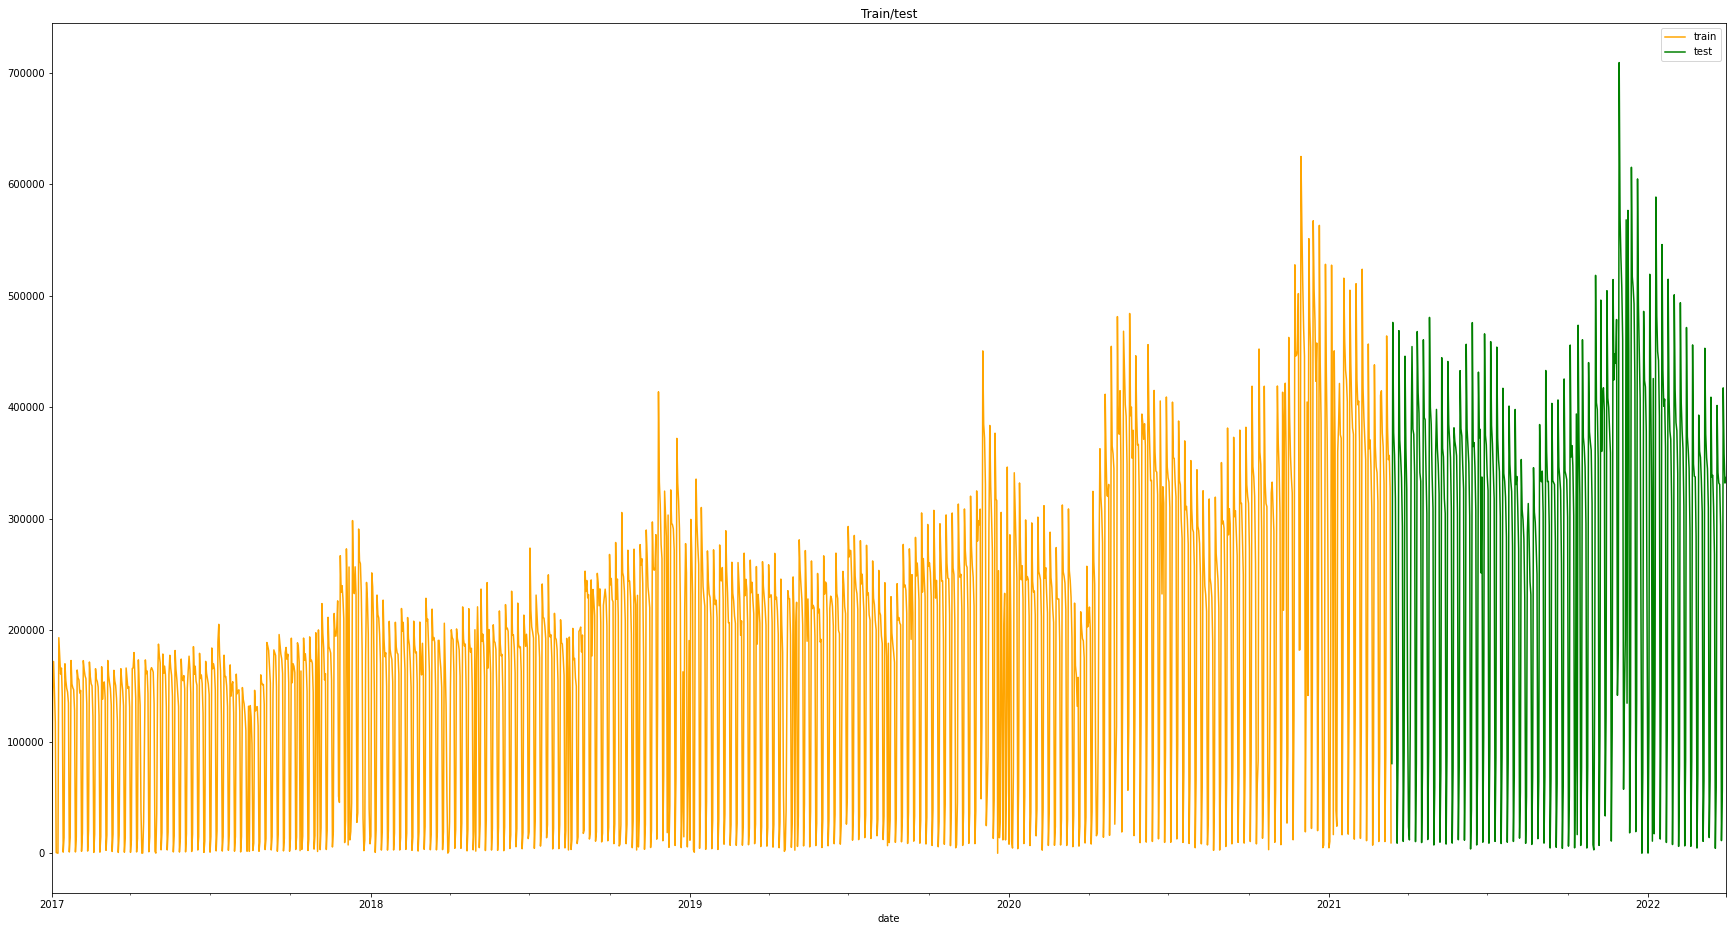

In [9]:
# show train and test
tr_2017_plot = train_2017_y.copy()
tr_2017_plot.index = Xforindex.iloc[:train_size].index
te_2017_plot = test_2017_y.copy()
te_2017_plot.index = Xforindex.iloc[train_size:].index
plot_train_test = pd.DataFrame()
plot_train_test = pd.concat([tr_2017_plot, te_2017_plot])
plot_train_test['train'] = tr_2017_plot
plot_train_test['test'] = te_2017_plot
plot_train_test['train'].plot(figsize=(30, 16), legend=True, color='orange')
plot_train_test['test'].plot(figsize=(30, 16), legend=True, color='green').set_title('Train/test')

Thus, our train and test are limited by the dates 2017-01-01 and 2021-03-13 in the case of the train and by the dates 2021-03-14 and 2022-03-31 in the case of the test.

# Models

We will now test different models and record their associated errors (RMSE, MAE) for comparison at the end.

The models are:

*   SARIMAX
*   PROPHET
*   RANDOM FOREST
*   XGBOOST
*   LSTM

In [10]:
# declare errors dataframe in order to record models errors (RMSE and MAE)
errors = pd.DataFrame()
errors = pd.DataFrame(columns=['RMSE','MAE'])
errores = {}

**SARIMAX**

The first model we are going to implement is SARIMAX. SARIMAX is essentially a linear regression model that uses a seasonal ARIMA-type model of the residuals.

For this we will first use auto_arima to choose the most appropriate parameters and then we will implement the SARIMAX model to train it and see its performance with test data. It is important to know that we have to pass the scaled data to this algorithm.

In [11]:
# run auto arima
model_auto_arima = auto_arima(scaled_train_2017_y, exogenous=scaled_train_2017_X, 
                     start_p=1, start_q=1, 
                     max_p=8, max_q=8,  
                     d=1, max_d=8, 
                     trace=True, 
                     error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4817.199, Time=5.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4344.217, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4540.360, Time=3.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4789.060, Time=4.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4346.215, Time=2.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4821.666, Time=5.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4621.956, Time=4.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4784.598, Time=6.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4797.834, Time=6.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4815.961, Time=5.83 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4701.685, Time=5.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4809.093, Time=6.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4824.480, Time=5.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4822.099, Time=5.16 sec
 ARIMA(2,1,0)(0,0,0

Now we pass the best parameters calculated by auto arima to the SARIMAX model. Then, the model is fitted and test predictions are calculated and plotted.

In [12]:
# SARIMAX model
model_sarimax = SARIMAX(scaled_train_2017_y, exog=scaled_train_2017_X, order=model_auto_arima.get_params()['order'], enforce_invertibility=False, enforce_stationarity=False)
# fit
sarimax_fitted = model_sarimax.fit()
# predict test
sarimax_scaled_predictions_test = sarimax_fitted.predict(start=train_size, end=train_size+test_size-1, exog=scaled_test_2017_X)

c:\Users\davidlopez\Desktop\PROYECTOS\TFM_ParcelForecasting\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


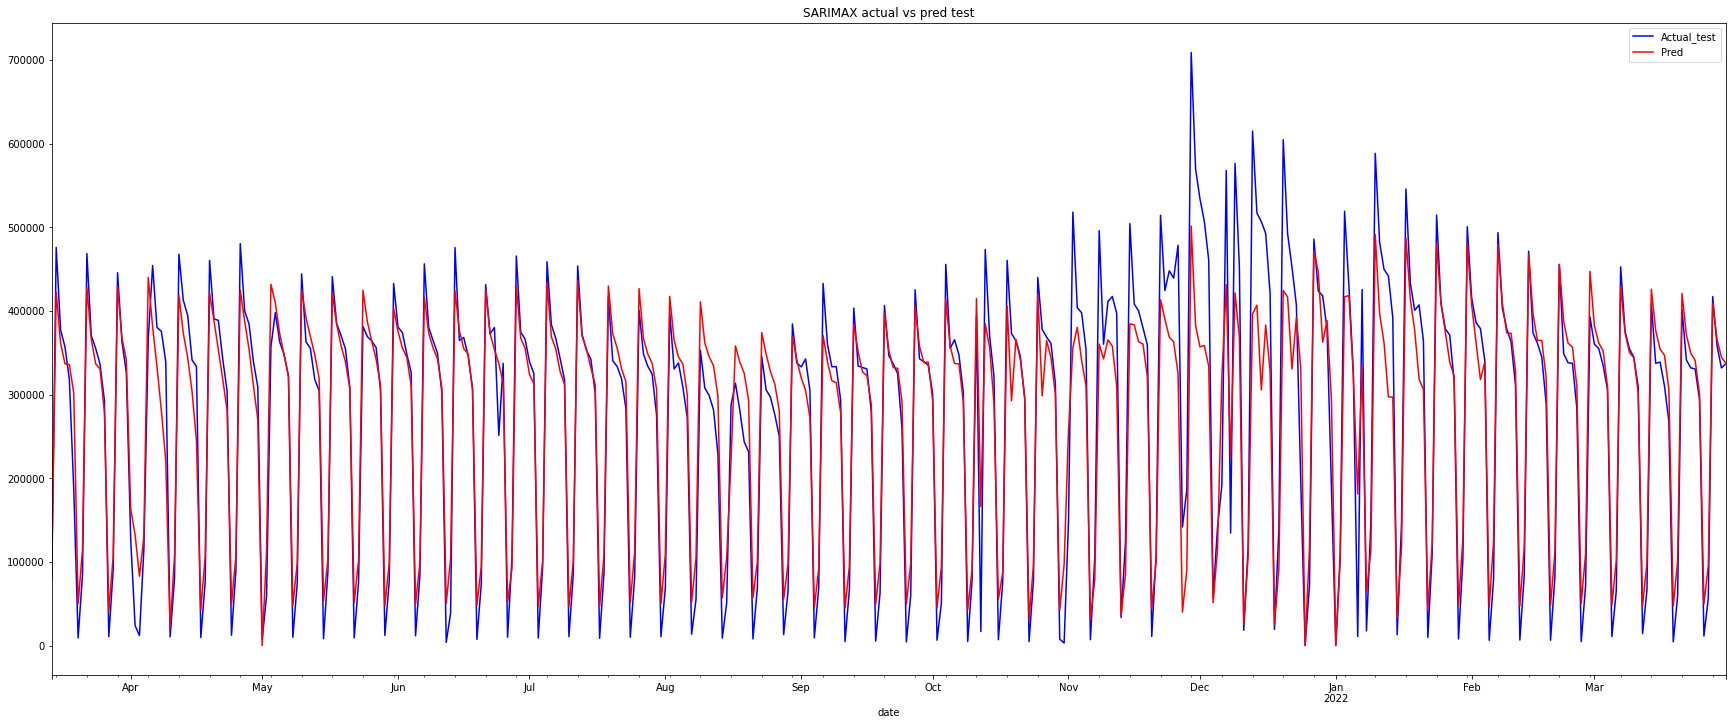

In [13]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
prepare_unscaled = scaled_test_2017_X.copy()
prepare_unscaled['scaled_pred'] = sarimax_scaled_predictions_test.values
unscaled_predictions = scaler_1.inverse_transform(prepare_unscaled)
predictions = pd.DataFrame(unscaled_predictions[:, -1:])
predictions.index = test_2017_X.index
predictions['Actual_test'] = act_test['n_parcels']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions.index = Xforindex.iloc[train_size:].index
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('SARIMAX actual vs pred test')
predictions_SARIMAX = predictions.copy()

In [14]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_SARIMAX['Pred'], predictions_SARIMAX['Actual_test']), meanabs(predictions_SARIMAX['Pred'], predictions_SARIMAX['Actual_test'])]

**PROPHET**

The second model we are going to implement is Prophet. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

First, we will generate the calendars and datasets with the format required by Prophet and then we will test it to see and save its results.

In [15]:
# generate holidays

h_nationals = pd.DataFrame({
    'holiday': 'national',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['fest']].index)
})

h_saturdays = pd.DataFrame({
    'holiday': 'saturdays',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['saturday']].index)
})

h_sundays = pd.DataFrame({
    'holiday': 'sundays',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['sunday']].index)
})

h_black_friday = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['blackFriday']].index)
})

h_black_friday_week = pd.DataFrame({
    'holiday': 'black_friday_week',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['blackFridayWeek']].index)
})

h_covid = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['COVID']].index)
})

h_christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['Christmas']].index)
})

df_holidays = pd.concat((h_nationals, h_saturdays, h_sundays, h_black_friday, h_black_friday_week, h_covid, h_christmas))

In this case we can pass the data without scaling because prophet takes care of it.

In [16]:
# prepare data
train_prophet_ex = pd.DataFrame()
train_prophet_ex = X[['gap-1',	'gap-2',	'gap-3',	'gap-4', 'gap-6', 'gap-7', 'gap-14',	'gap-21',	'gap-28',	'gap-365']][:train_size].copy()
train_prophet_ex['ds'] = Xforindex.iloc[:train_size].index
train_prophet_ex['y'] = train_2017_y.values

Initially, the notebooks were developed in Google Colab, where prophet could be imported without problems. However, in this development environment it has been impossible to properly install the module. Therefore, the code is shown commented, the images with the output are added and the error is added to the error dataframe. In addition, these can be found in memory.

In [17]:
# Prophet model
#model_prophet = Prophet(holidays=df_holidays)
# add regressors with lags
#model_prophet.add_regressor('gap-1')
#model_prophet.add_regressor('gap-2')
#model_prophet.add_regressor('gap-2')
#model_prophet.add_regressor('gap-3')
#model_prophet.add_regressor('gap-4')
#model_prophet.add_regressor('gap-6')
#model_prophet.add_regressor('gap-7')
#model_prophet.add_regressor('gap-14')
#model_prophet.add_regressor('gap-21')
#model_prophet.add_regressor('gap-28')
#model_prophet.add_regressor('gap-365')
# Fit
#model_prophet.fit(train_prophet_ex)
# Forecast
#future = model_prophet.make_future_dataframe(periods=test_size)
#future = pd.concat([future, X[['gap-1',	'gap-2',	'gap-3',	'gap-4', 'gap-6', 'gap-7', 'gap-14',	'gap-21',	'gap-28', 'gap-365']]], axis=1)
#forecast_prophet = model_prophet.predict(future)

In [18]:
# plot forecast components
#fig = model_prophet.plot_components(forecast_prophet)

<img src="./images_prophet/p1.png">
<img src="./images_prophet/p2.png">

In [19]:
# prepare and plot test data and predictions
#act_test = pd.DataFrame(y.iloc[train_size:])
#predictions = pd.DataFrame()
#predictions['Pred'] = forecast_prophet['yhat'][train_size:]
#predictions['Actual_test'] = act_test['n_parcels']
#predictions.reset_index(drop=True, inplace=True)
#predictions.index = Xforindex.iloc[train_size:].index
#predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
#predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
#predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('Prophet actual vs pred test')
#predictions_Prophet = predictions.copy()

<img src="./images_prophet/p4.png">

In [20]:
# record errors
errors.loc[len(errors.index)] = [55870.203534,	42357.515211]

**RANDOM FOREST**

The next and third model we are going to implement is Random Forest for regression. A Random Forest is an ensemble of decision trees combined with bagging. When using bagging, what is actually happening is that different trees see different portions of the data. No single tree sees all of the training data. This results in each tree being trained with different data samples for the same problem. In this way, by combining their results, some errors are compensated by others and we have a prediction that generalizes better.

To do this, we will first make use of grid search to obtain the best parameters and, as before, we will then train the model and test it with the test data to calculate its associated errors and plot the results.

In this case we can use the data without scaling, since this type of algorithm does not need it.

In [21]:
# run Random Forest Regressor in GridSearchCV
gsRFreg = GridSearchCV(RandomForestRegressor(),
                   param_grid={"max_depth":  [25, 50, 75, 100], 
                              "n_estimators": [50, 75, 100, 125, 150],
                                "max_features": ["auto", "log2"],
                                "bootstrap": [True, False]},
                   scoring="neg_mean_squared_error",
                   verbose=2)

gsRFreg.fit(train_2017_X, train_2017_y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [25, 50, 75, 100],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [22]:
# run Random Forest Regressor
estimatorRFR = RandomForestRegressor(n_jobs=-1).set_params(**gsRFreg.best_params_)
estimatorRFR.fit(train_2017_X, train_2017_y)
y_predictRFR = estimatorRFR.predict(test_2017_X)

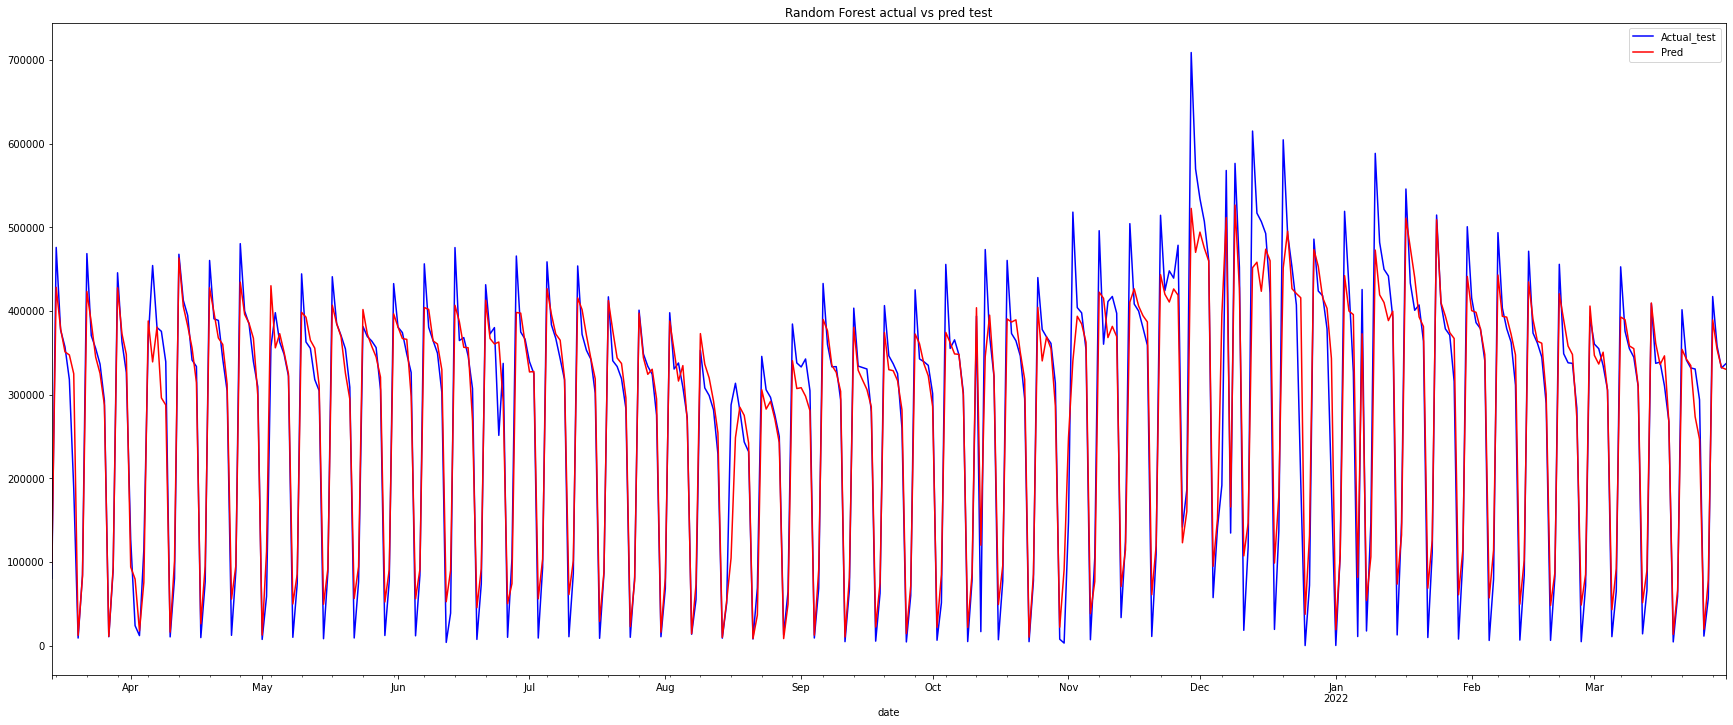

In [23]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = y_predictRFR
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('Random Forest actual vs pred test')
predictions_RF = predictions.copy()

<BarContainer object of 17 artists>

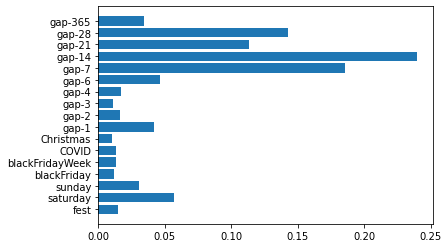

In [24]:
# feature importances
plt.barh(train_2017_X.columns, estimatorRFR.feature_importances_)

In [25]:
# Record errors
errors.loc[len(errors.index)] = [rmse(predictions_RF['Pred'], predictions_RF['Actual_test']), meanabs(predictions_RF['Pred'], predictions_RF['Actual_test'])]

**XGBoost**

The fourth model we are going to implement is XGBoost for regression. XGBoost is an efficient implementation of gradient boosting that can be used for regression predictive modeling.

To do this, we will first make use of grid search to obtain the best parameters and, as before, we will then train the model and test it with the test data to calculate its associated errors and plot the results.

In this case we can use the data without scaling, since this type of algorithm does not need it.

In [26]:
# run XGBoost in GridSearchCV
gscXGB = GridSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={'n_estimators': [750, 1000, 1250, 1500],
                        },
                   scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

gscXGB.fit(train_2017_X, train_2017_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[03:48:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [750, 1000, 1250, 1500]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [27]:
# run XGBoost Regressor
estimatorXGB = xgb.XGBRegressor(n_estimators=gscXGB.best_params_['n_estimators'])
estimatorXGB.fit(train_2017_X, train_2017_y, verbose=False)
y_predictXGB = estimatorXGB.predict(test_2017_X)

[03:48:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


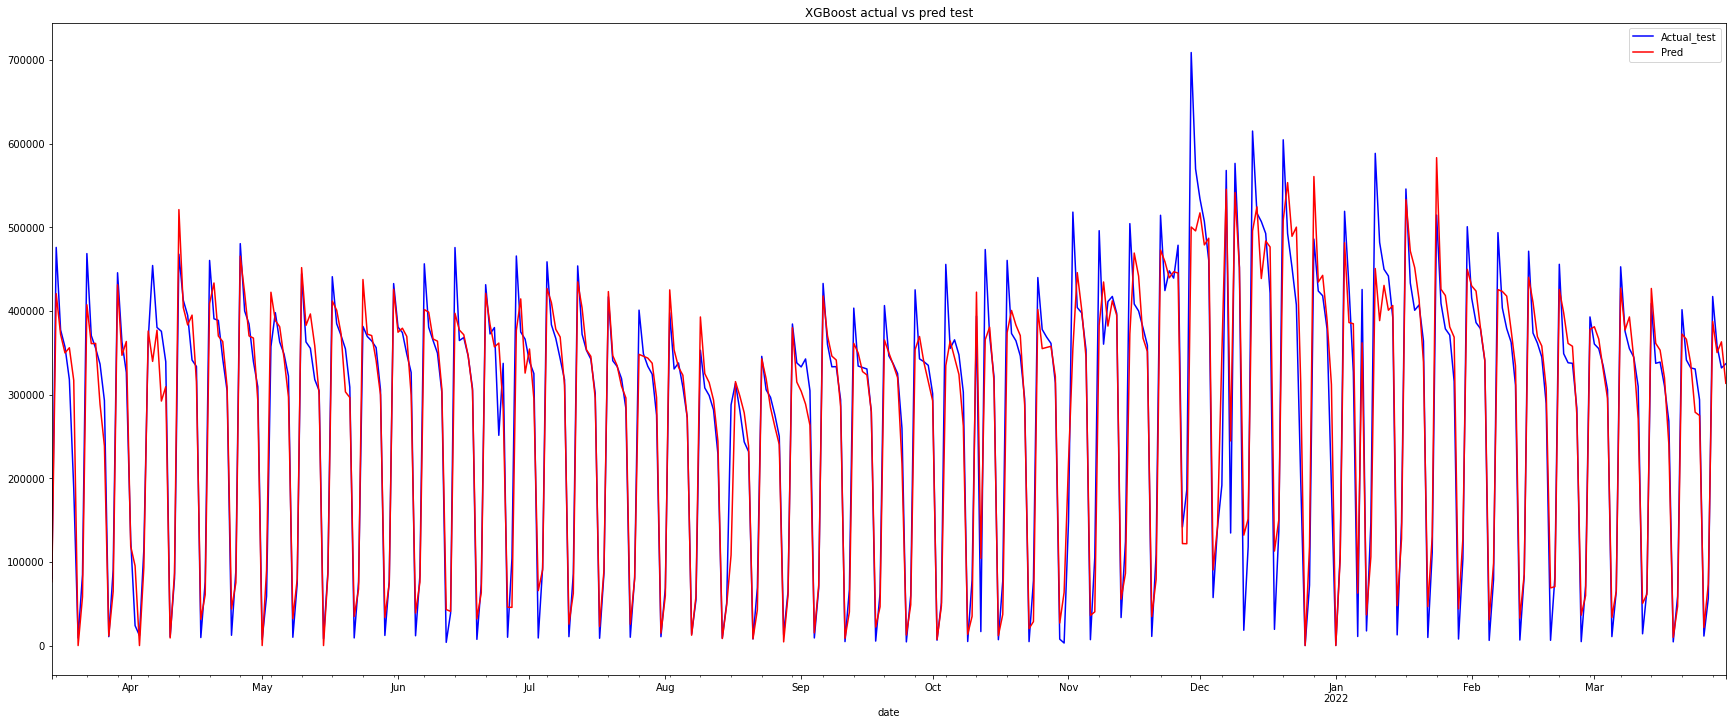

In [28]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = y_predictXGB
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('XGBoost actual vs pred test')
predictions_XGB = predictions.copy()

<BarContainer object of 17 artists>

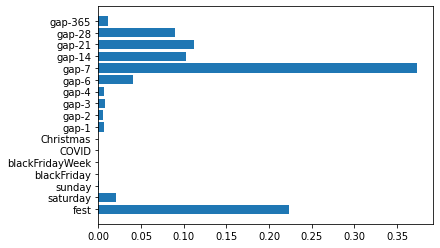

In [29]:
# feature importances
plt.barh(train_2017_X.columns, estimatorXGB.feature_importances_)

In [30]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_XGB['Pred'], predictions_XGB['Actual_test']), meanabs(predictions_XGB['Pred'], predictions_XGB['Actual_test'])]

**LSTM**

The fifth and last algorithm we will implement is LSTM. LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.

In this case we do have to use the scaled dataset and, in addition, we have to reshape the data to the shape required by the LSTMs. Then we will train the network with the train data and standard parameters and finally we will check and visualize its results with the test data.

In [31]:
# prepare data
scaled_train_2017_X_lstm_np = scaled_train_2017_X.to_numpy()
scaled_train_2017_y_lstm_np = scaled_train_2017_y.to_numpy()
scaled_test_2017_X_lstm_np = scaled_test_2017_X.to_numpy()
scaled_test_2017_y_lstm_np = scaled_test_2017_y.to_numpy()

scaled_train_2017_X_lstm = scaled_train_2017_X_lstm_np.reshape((scaled_train_2017_X_lstm_np.shape[0], 1, scaled_train_2017_X_lstm_np.shape[1]))
scaled_test_2017_X_lstm = scaled_test_2017_X_lstm_np.reshape((scaled_test_2017_X_lstm_np.shape[0], 1, scaled_test_2017_X_lstm_np.shape[1]))

In [32]:
# LSTM
# set LSTM parameters
dropoutIndex = 0.0
neuronsLSTMLayer = 50
neuronsOutputLayer = 1
lossFunction = 'mean_squared_error'
Optimizer = 'adam'
Epochs = 80
batchSize = 64

# model
model = Sequential()
model.add(LSTM(neuronsLSTMLayer, input_shape = (scaled_train_2017_X_lstm.shape[1], scaled_train_2017_X_lstm.shape[2])))
model.add(Dropout(dropoutIndex))
model.add(Dense(neuronsOutputLayer))
model.compile(loss = lossFunction, optimizer = Optimizer)

# fit
history = model.fit(scaled_train_2017_X_lstm, scaled_train_2017_y_lstm_np, epochs = Epochs, batch_size = batchSize, validation_data = (scaled_test_2017_X_lstm, scaled_test_2017_y_lstm_np), verbose = 2, shuffle=False)

Epoch 1/80
24/24 - 3s - loss: 0.0442 - val_loss: 0.0482 - 3s/epoch - 108ms/step
Epoch 2/80
24/24 - 0s - loss: 0.0091 - val_loss: 0.0137 - 77ms/epoch - 3ms/step
Epoch 3/80
24/24 - 0s - loss: 0.0048 - val_loss: 0.0088 - 83ms/epoch - 3ms/step
Epoch 4/80
24/24 - 0s - loss: 0.0035 - val_loss: 0.0067 - 73ms/epoch - 3ms/step
Epoch 5/80
24/24 - 0s - loss: 0.0033 - val_loss: 0.0060 - 79ms/epoch - 3ms/step
Epoch 6/80
24/24 - 0s - loss: 0.0031 - val_loss: 0.0057 - 84ms/epoch - 3ms/step
Epoch 7/80
24/24 - 0s - loss: 0.0030 - val_loss: 0.0054 - 84ms/epoch - 4ms/step
Epoch 8/80
24/24 - 0s - loss: 0.0029 - val_loss: 0.0052 - 82ms/epoch - 3ms/step
Epoch 9/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0051 - 81ms/epoch - 3ms/step
Epoch 10/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0049 - 78ms/epoch - 3ms/step
Epoch 11/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0049 - 77ms/epoch - 3ms/step
Epoch 12/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0048 - 76ms/epoch - 3ms/step
Epoch 13/80
24/24 - 0s - loss: 0.0027

In [33]:
# test prediction
yhat = model.predict(scaled_test_2017_X_lstm)
a = scaled_test_2017_X_lstm.reshape((scaled_test_2017_X_lstm.shape[0], scaled_test_2017_X_lstm.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((a, yhat), axis=1)
inv_yhat = scaler_1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

12/12 [==============================] - 1s 1ms/step


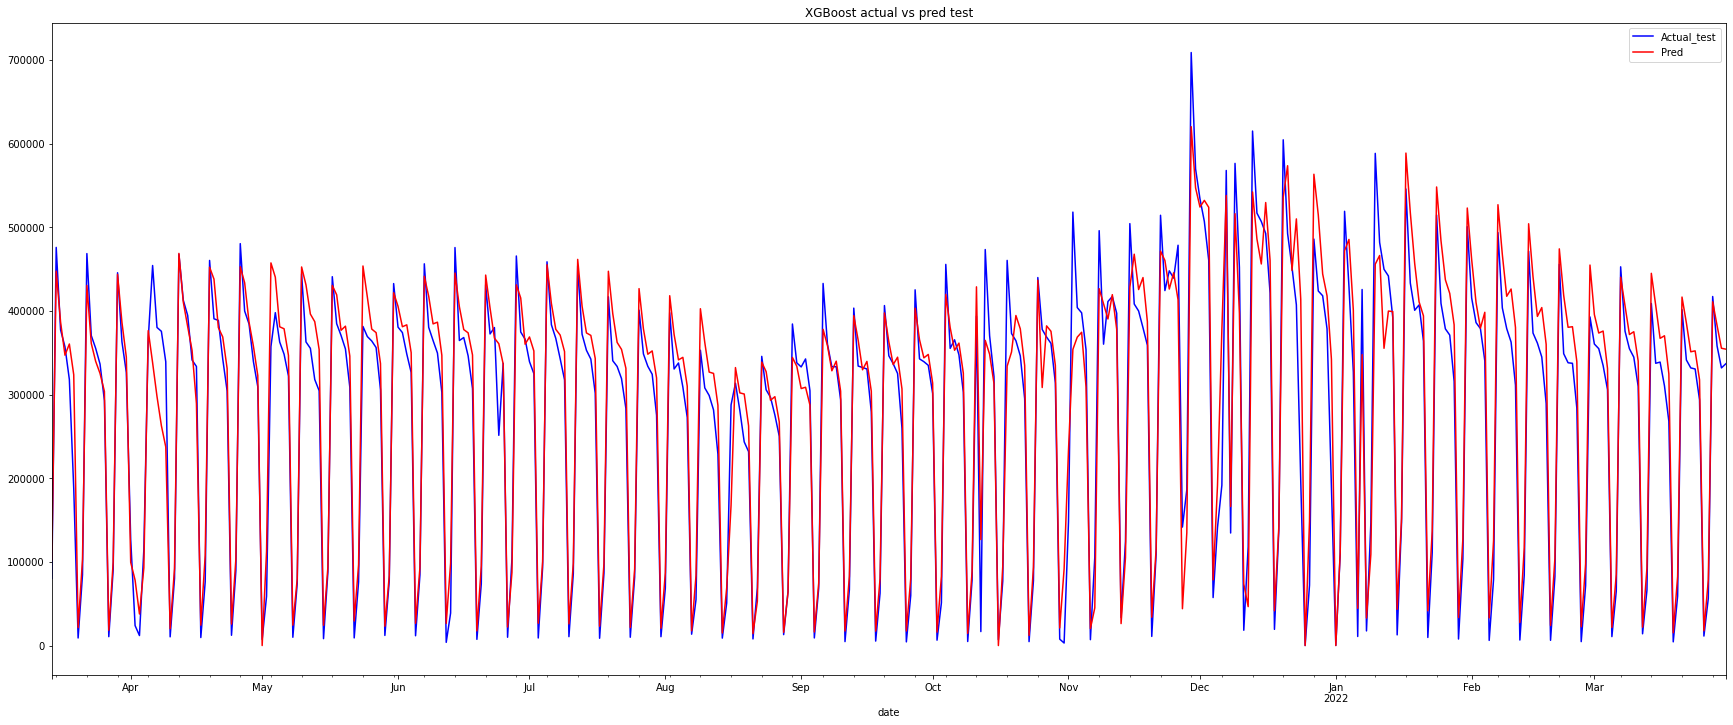

In [34]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = inv_yhat
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('XGBoost actual vs pred test')
predictions_LSTM = predictions.copy()

In [35]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_LSTM['Pred'], predictions_LSTM['Actual_test']), meanabs(predictions_LSTM['Pred'], predictions_LSTM['Actual_test'])]

# Evaluation

In this section we are going to analyze the errors of the models in order to choose the best one for our future predictions.

We have chosen the errors RMSE and MAE. This is because the rmse gives importance to high and low values which in our case are shown on weekends or black friday and the MAE provides a more general view of the error.

In [36]:
# errors recorded
errors['models'] = ['SARIMAX', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM']
errors

,RMSE,MAE,models
0,53656.031948,37667.855030,SARIMAX
1,55870.203534,42357.515211,Prophet
2,43038.645979,28446.533333,Random Forest
3,41747.458484,28268.717799,XGBoost
4,44309.176589,32895.535143,LSTM


Text(0.5, 1.0, 'RMSE comparison')

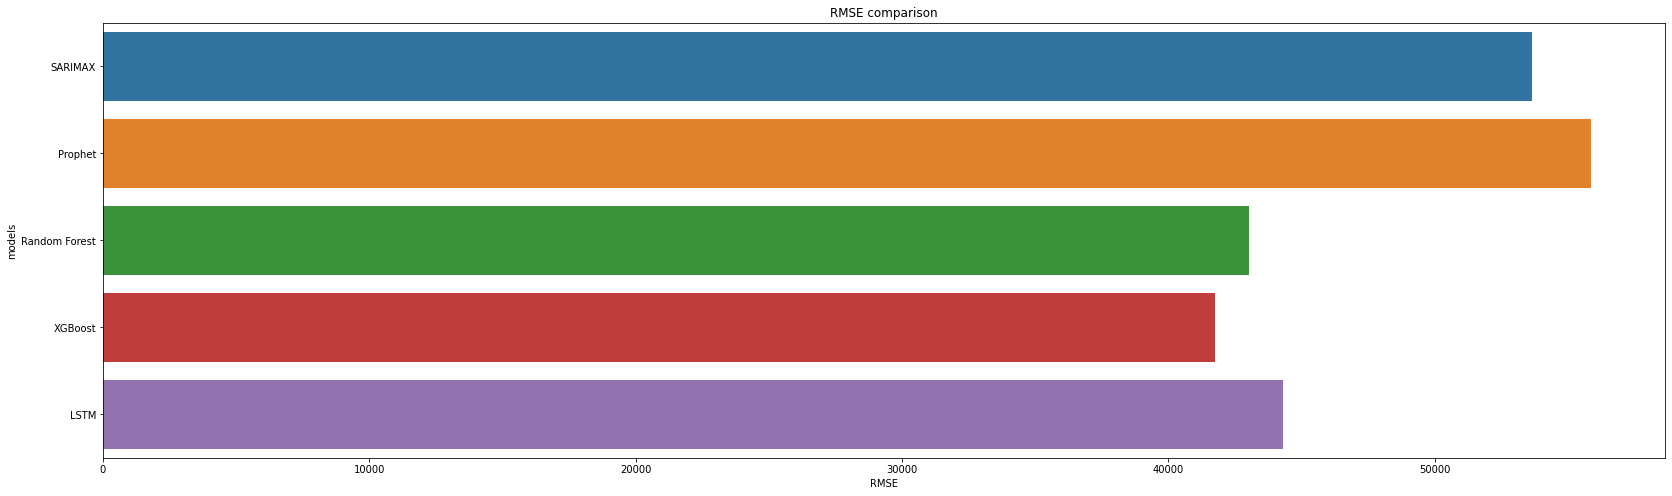

In [37]:
# plot rmse
plt.figure(figsize=(28, 8))
sns.barplot(data=errors, x='RMSE', y='models').set_title('RMSE comparison')

Text(0.5, 1.0, 'MAE comparison')

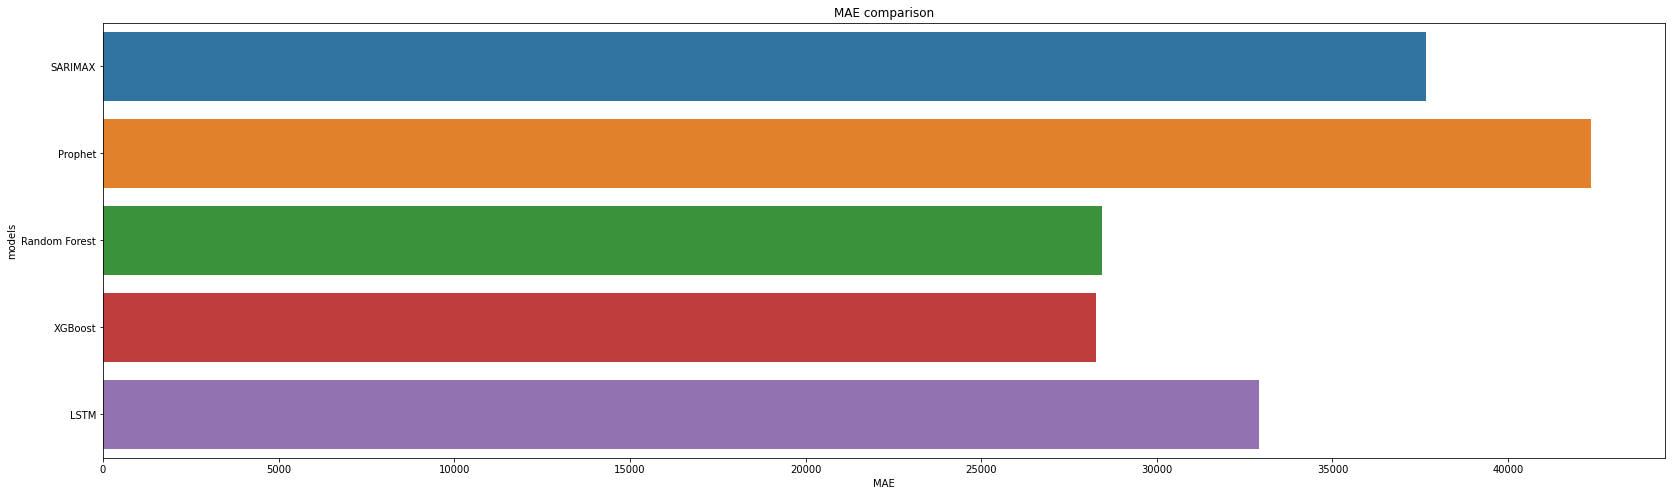

In [38]:
# plot mae
plt.figure(figsize=(28, 8))
sns.barplot(data=errors, x='MAE', y='models').set_title('MAE comparison')

We can see Random Forest and XGBoost models provide the best results for the two errors. In the case of RMSE the XGBoost is slightly better and the opposite in the case of MAE. Further back we find LSTM and the worst models are SARIMAX and Prophet.

We could choose either Random Forest or XGBoost, but since we have to choose one, we choose XGBoost because the combined error is slightly better.

Let's plot the results for train and test for **XGBoost**.

Text(0.5, 1.0, 'XGBoost train, test and pred')

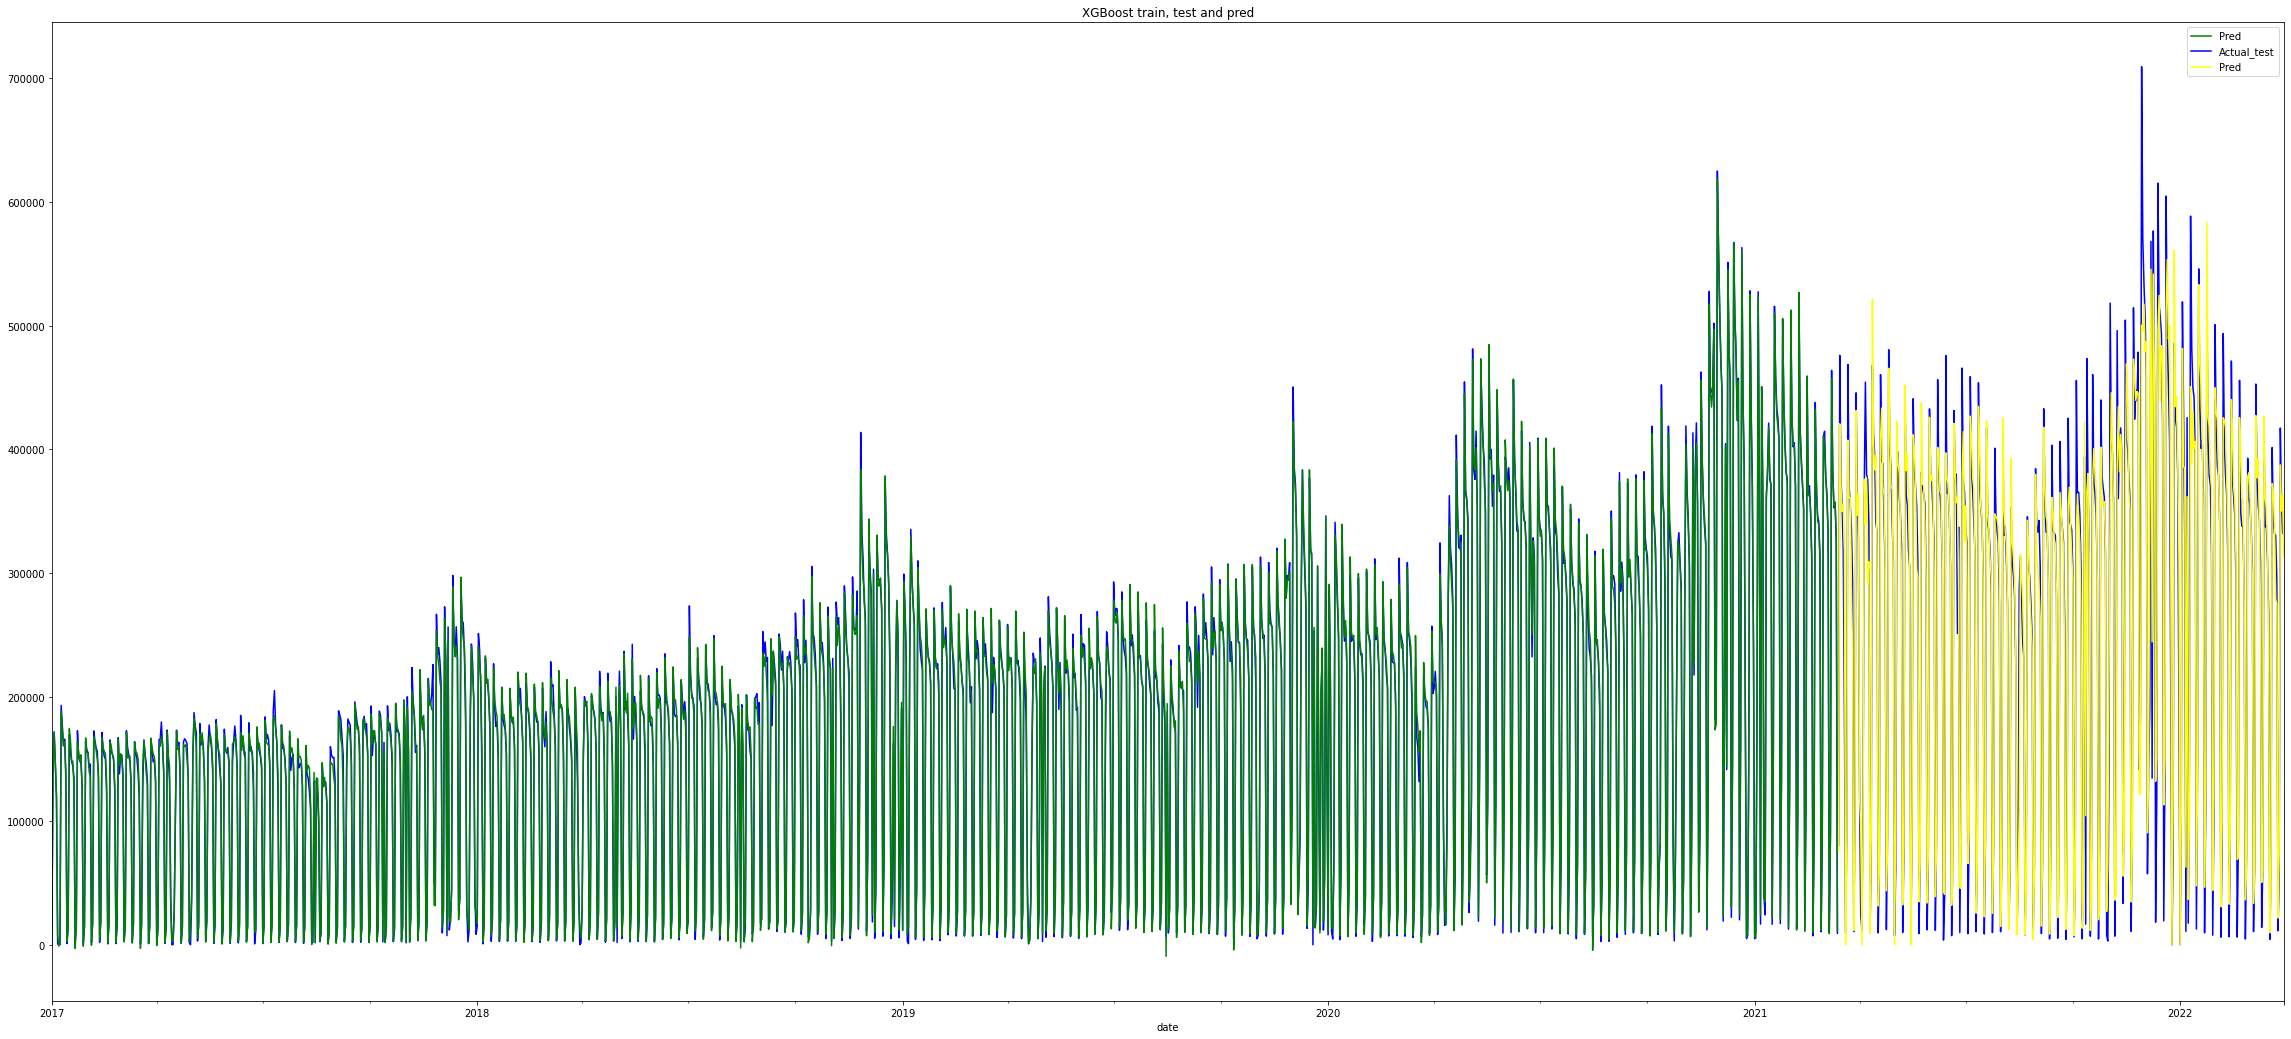

In [39]:
# Predict train
y_predictXGBtrain = estimatorXGB.predict(train_2017_X)
# Prepare and plot train and test data and predictions
act_train = pd.DataFrame(y.iloc[:train_size])
act_train.index = Xforindex.iloc[:train_size].index
predictions_XGB_train = pd.DataFrame()
predictions_XGB_train['Pred'] = y_predictXGBtrain
predictions_XGB_train.index = Xforindex.iloc[:train_size].index
predictions_XGB_train['Actual_train'] = act_train['n_parcels']
predictions_XGB_train['Actual_train'].plot(figsize=(40, 18), legend=False, color='blue')
predictions_XGB_train['Pred'].plot(figsize=(40, 18), legend=True, color='green')
predictions_XGB['Actual_test'].plot(figsize=(40, 18), legend=True, color='blue')
predictions_XGB['Pred'].plot(figsize=(40, 18), legend=True, color='yellow').set_title('XGBoost train, test and pred')

Now we need to train the model with all the data in order to use it later.

In [40]:
# Train model with all data
estimatorXGB_all = xgb.XGBRegressor(n_estimators=gscXGB.best_params_['n_estimators'])

estimatorXGB_all.fit(X, y)

[03:48:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=750)

Let's calculate the errors for the case with all the data, train and test.

Text(0.5, 1.0, 'XGBoost all data fit')

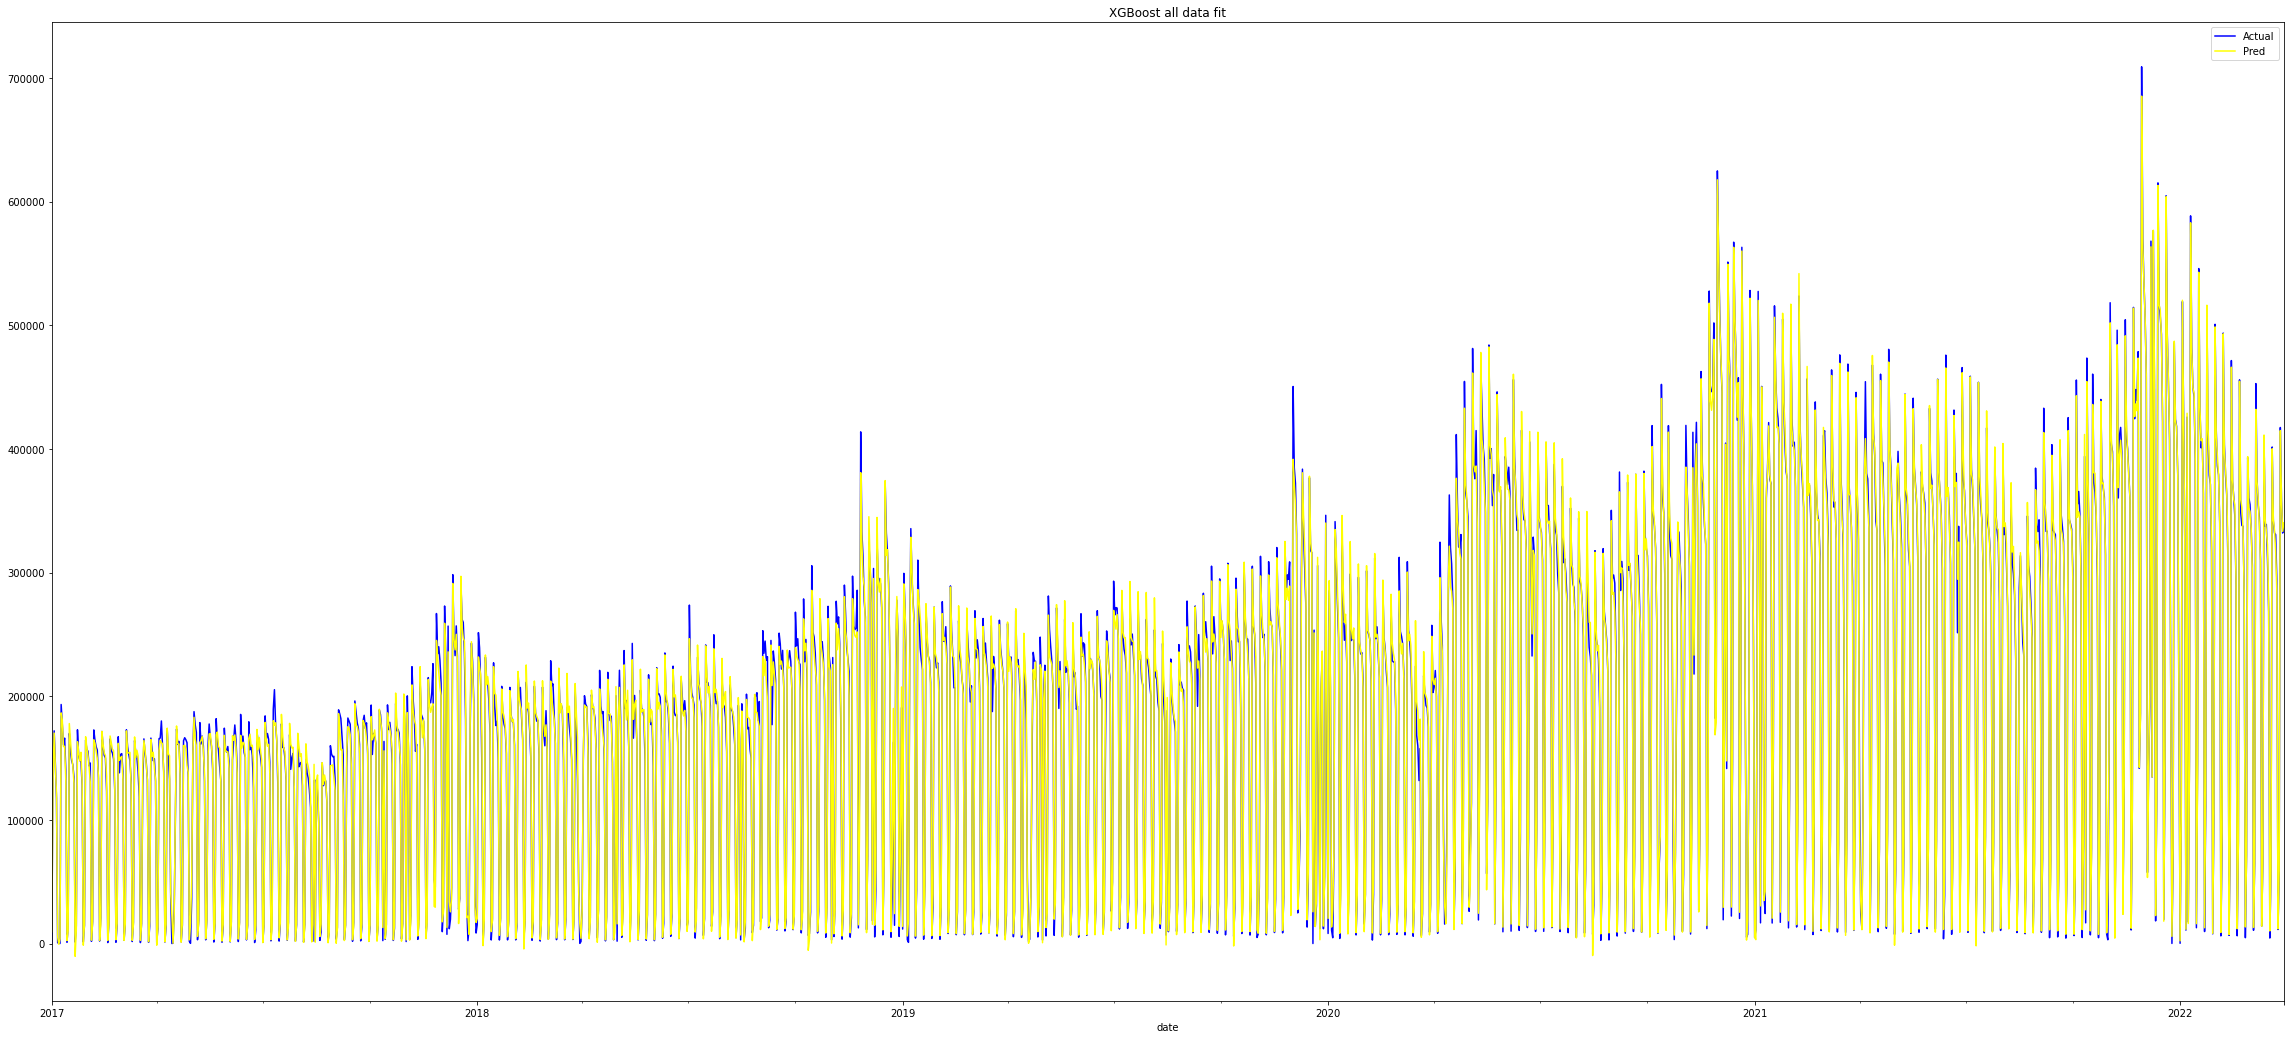

In [41]:
# Predict all data
y_predictXGBall = estimatorXGB_all.predict(X)
# Prepare and plot train and test data and predictions
predictions_XGB_all = pd.DataFrame()
predictions_XGB_all['Pred'] = y_predictXGBall
predictions_XGB_all['Actual'] = y
predictions_XGB_all.index = Xforindex.index
predictions_XGB_all['Actual'].plot(figsize=(40, 18), legend=True, color='blue')
predictions_XGB_all['Pred'].plot(figsize=(40, 18), legend=True, color='yellow').set_title('XGBoost all data fit')

In [42]:
# Print errors
print("RMSE")
print("Test: ", rmse(predictions_XGB['Pred'], predictions_XGB['Actual_test']))
print("Train: ", rmse(predictions_XGB_train['Pred'], predictions_XGB_train['Actual_train']))
print("All: ", rmse(predictions_XGB_all['Pred'], predictions_XGB_all['Actual']))
print("MAE")
print("Test: ", meanabs(predictions_XGB['Pred'], predictions_XGB['Actual_test']))
print("Train: ", meanabs(predictions_XGB_train['Pred'], predictions_XGB_train['Actual_train']))
print("All: ", meanabs(predictions_XGB_all['Pred'], predictions_XGB_all['Actual']))

RMSE
Test:  41747.45848379637
Train:  7397.914174484705
All:  10064.838343348687
MAE
Test:  28268.717798935217
Train:  5281.707952928637
All:  7100.831418572985


These results show that there is no overfitting beacuse the error in the case with all the data is greater than with the train.

Finally, this model is saved so that we can use it later.

In [45]:
import joblib
filename = '../files/save_model/XGB_model.sav'
joblib.dump(estimatorXGB_all, filename)

['../files/save_model/XGB_model.sav']